This code will load the model information, generate the model definition, and run the model estimation using FSL

In [1]:
import nipype.algorithms.modelgen as model   # model generation
import nipype.interfaces.fsl as fsl          # fsl
from nipype.interfaces.base import Bunch
import os,json,glob
import numpy
import nibabel
import nilearn.plotting

from make_event_files_from_json import MakeEventFilesFromJSON
%matplotlib inline
import matplotlib.pyplot as plt


try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'
    
results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

from nipype.caching import Memory
mem = Memory(base_dir='.')

print 'Using data from',datadir

Using data from /home/vagrant/data


Load the scan and model info, and generate the event files for FSL from the information in model.json

In [2]:
subject='sub00001'
session='ses014'  
# note - we have to use the anatomy from a different session'
subdir=os.path.join(datadir,'ds031', subject, session)
tasknum=2 # n-back

preprocessed_epi = os.path.join(results_dir, "preprocessed_epi_native_space.nii.gz")

scaninfo=json.load(open(os.path.join(subdir,
        'functional/sub00001_ses014_task002_run001_bold.json')))
tr=scaninfo['RepetitionTime']

modelfile=os.path.join(subdir,'model.json')
modelinfo=json.load(open(modelfile))
taskinfo=modelinfo['task%03d'%tasknum]['model001']
evs=taskinfo['Variables']
contrasts=taskinfo['Contrasts']

# get the response onsets
response_onsets=[]

for v in evs.iterkeys():

    if evs[v]['VariableName'].find('_target_ons')>-1:
        for ons in evs[v]['onsets']:
            response_onsets.append(ons[0])

Specify the model.  For the sake of speed we will use a simplified model that treats the study as a blocked design rather than modeling each item separately, but we also model instructions and motor responses; this, it is a hybrid block/event-related design

In [3]:
#modeldir=os.path.join(subdir,'model/task%03d/model001/featmodel'%tasknum)
# no way to specify the output directory, so we just chdir into the 
# desired output directory
#if not os.path.exists(modeldir):
#    os.mkdir(modeldir)
#os.chdir(modeldir)

instruction_onsets=list(numpy.array([68,176,372,2,154,416,24,220,350,112,198,328,46,264,394,90,242,306])-2.0)

info = [Bunch(conditions=['faces-1back',
                          'faces-2back',
                          'scenes-1back',
                          'scenes-2back',
                          'chars-1back',
                          'chars-2back',
                          'instructions',
                          'responses'],
              onsets=[[68,176,372],
                      [2,154,416],
                      [24,220,350],
                      [112,198,328],
                      [46,264,394],
                      [90,242,306],
                      instruction_onsets,
                      response_onsets],
              durations=[[20],
                         [20],
                         [20],
                         [20],
                         [20],
                         [20],
                         [2],
                         [1]])
       ]

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = preprocessed_epi
s.inputs.time_repetition = 6
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

Generate the fsf and ev files using Level1Design

In [4]:
contrasts=[['faces>Baseline','T', 
            ['faces-1back','faces-2back'],[0.5,0.5]],
           ['scenes>Baseline','T', 
            ['scenes-1back','scenes-2back'],[0.5,0.5]],
           ['chars>Baseline','T', 
            ['chars-1back','chars-2back'],[0.5,0.5]],
           ['2back>1back','T', 
            ['faces-1back','faces-2back','scenes-1back','scenes-2back','chars-1back','chars-2back'],[-1,1,-1,1,-1,1,-1,1]],
          ['response>Baseline','T',
           ['responses'],[1]],
          ['instructions>Baseline','T',
           ['instructions'],[1]]]
           
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = tr,
                                    bases = {'dgamma':{'derivs': True}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=True,
                                    contrasts=contrasts)

level1design_results.outputs

INFO:workflow:Executing node fd0e4b41992c6422157c4efe0fbf2570 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570



ev_files = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570/ev_faces-1back_0_1.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570/ev_faces-2back_0_3.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570/ev_scenes-1back_0_5.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570/ev_scenes-2back_0_7.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570/ev_chars-1back_0_9.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/fd0e4b41992c6422157c4efe0fbf2570/ev_chars-2back_0_11.txt', '/home/vagra

Generate the full set of model files using FEATModel

In [5]:
modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)
modelgen_results.outputs

INFO:workflow:Executing node e88c9cabfa8dd6a9d95fdc8320018009 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009
INFO:workflow:Running: feat_model run0 



con_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009/run0.con
design_cov = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009/run0_cov.png
design_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009/run0.mat
design_image = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009/run0.png
fcon_file = <undefined>

Visualize the design matrix

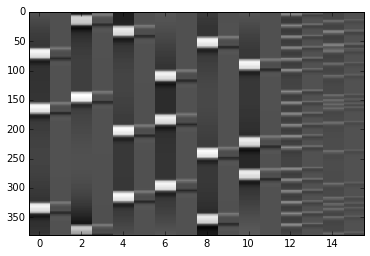

In [6]:
desmtx=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')

Show the correlation matrix for design

<matplotlib.colorbar.Colorbar instance at 0x7f9757750830>

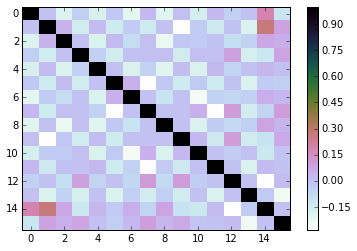

In [7]:
cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.cubehelix_r)
plt.colorbar()

Estimate the model using FILMGLS - this will take a few minutes.

In [11]:
fgls = mem.cache(fsl.FILMGLS)
fgls_results = fgls(in_file = preprocessed_epi,
                    autocorr_noestimate = True,
                    design_file = modelgen_results.outputs.design_file,
                    tcon_file = modelgen_results.outputs.con_file,
                    threshold= 1000,
                    full_data=True,
                    mask_size=5)
fgls_results.outputs

INFO:workflow:Executing node e759b53d5ad62afdf07d35d89c2e3740 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/e759b53d5ad62afdf07d35d89c2e3740
INFO:workflow:Running: film_gls --noest -v --ms=5 --rn=results --con=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009/run0.con --in=/home/vagrant/fmri-analysis-vm/analysis/results/preprocessed_epi_native_space.nii.gz --pd=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009/run0.mat --thr=1000.000000
INFO:interface:stdout 2015-08-13T00:33:46.241109:Log directory is: results
INFO:interface:stdout 2015-08-13T00:34:08.370892:paradigm.getDesignMatrix().Nrows()=380
INFO:interface:stdout 2015-08-13T00:34:08.375968:paradigm.getDesignMatrix().Ncols()=16
INFO:interface:stdout 2015-08-13T00:34:08.375968:sizeTS=380
INFO:interface:stdout 2

RuntimeError: Command:
film_gls --noest -v --ms=5 --rn=results --con=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009/run0.con --in=/home/vagrant/fmri-analysis-vm/analysis/results/preprocessed_epi_native_space.nii.gz --pd=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e88c9cabfa8dd6a9d95fdc8320018009/run0.mat --thr=1000.000000
Standard output:
Log directory is: results
paradigm.getDesignMatrix().Nrows()=380
paradigm.getDesignMatrix().Ncols()=16
sizeTS=380
numTS=626687
Standard error:
Uncaught exception!
Return code: 1
Interface FILMGLS failed to run. 

In [ ]:
zstats=glob.glob(os.path.join(modeldir,'stats/zstat*.nii.gz'))
zstats.sort()
meanimg=nibabel.load(os.path.join(results_dir, "meanbold.nii.gz"))

for zstat in fgls_results.outputs.zstats:
    fmap_display=nilearn.plotting.plot_stat_map(zstat,meanimg,threshold=2.3,
                title='Contrast %d: %s'%(connum,contrasts[connum-1][0]))

In [ ]:
!fslview {preprocessed_epi}